# MSE for Similarity

Surprise!

It's a well-developed CF wrapper that handles what we've just discovered, and more

To utilize this, we need to create our custom similarity algorithm as it only implements:
- Cosine
- Correlation

## Our Similarity Algorithm

As a reminder, our algorithm is x ^ e ^ s = y, where sigma describes how much better is Player Y than Player X. Let's draw it out too

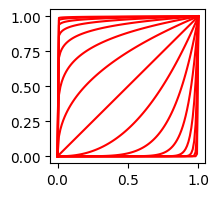

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer

x = np.linspace(0, 1, 100)
plt.figure(figsize=(2, 2))
for s in np.linspace(-6, 6, 15):
    plt.plot(x, x ** np.exp(s), color='red')

In [107]:
import warnings
from pathlib import Path

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top10k").joined_filtered_df,
    unpopular_maps_thres=0.2,
    unpopular_plays_thres=0.2,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)
df = df.set_index(['map_id', 'user_id', 'year'])
df = df.rename({'accuracy': 'acc'}, axis=1)
qt = QuantileTransformer()
df[['acc_qt']] = qt.fit_transform(df['acc'].to_numpy().reshape(-1, 1))

by_score_year 6021393 -> 3913111
by_sr 3913111 -> 3303754
by_unpopular_maps 3303754 -> 1328547
by_unpopular_plays 1328547 -> 571342
by_acc_filter 571342 -> 570513
by_remove_mod 570513 -> 550265
Users Left: 3989 | Beatmaps Left: 386


To streamline our analysis here, we create a function that illustrates the relationship with sim and plots

In [168]:
from opal.score.similarity.nb_utils import fit_sim, fit_sigma, sigma_to_sim

def analyze_pair(uid_ix_i, uid_ix_j):
    uid_i = df.index.get_level_values(1)[uid_ix_i]
    uid_j = df.index.get_level_values(1)[uid_ix_j]
    df_common = df.loc[:, uid_i, :].merge(df.loc[:, uid_j, :], on='map_id')

    sigma = fit_sigma(df_common['acc_qt_x'], df_common['acc_qt_y'])
    sim = sigma_to_sim(sigma)

    plt.figure(figsize=(6, 3))
    plt.gcf().text(0, 1, f"Sigma: {float(sigma):.2f}, Similarity: {sim:.2f}")
    plt.subplot(131)
    plt.scatter(df_common['acc_qt_x'], df_common['acc_qt_y'], s=1)
    plt.plot((x:=np.linspace(0, 1, 50)),x ** np.exp(sigma),
             label="Fitted Exponential", color='green',)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Quantile Transformed")
    plt.xlabel("Player X")
    plt.ylabel("Player Y")
    plt.subplot(132)
    plt.scatter(df_common['acc_x'], df_common['acc_y'], s=1)
    plt.xlim(0.85, 1)
    plt.ylim(0.85, 1)
    plt.title("Non-Quantile Transformed")
    plt.xlabel("Player X")
    plt.ylabel("Player Y")
    plt.subplot(133)
    plt.scatter(df_common['acc_qt_x'], df_common['acc_qt_y'] - df_common['acc_qt_x'], s=1)
    plt.title("QT Delta")
    plt.xlabel("Player X")
    plt.ylabel("Player Y-X")
    plt.tight_layout()
    plt.show()


Here, we see 2 players relatively similar

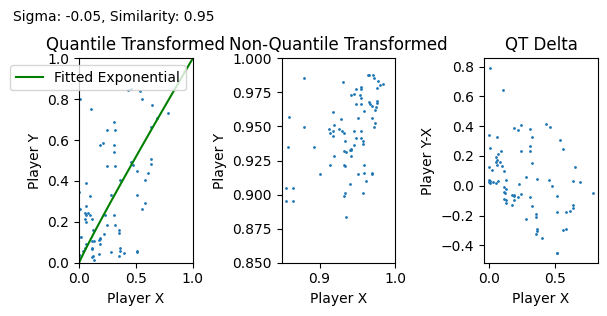

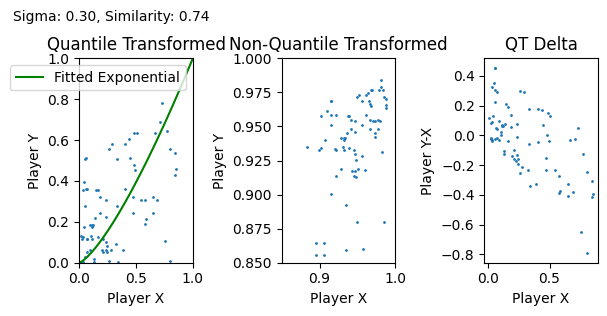

In [169]:
analyze_pair(0, 1)
analyze_pair(1, 0)

And 2 players not similar, in 2 different cases

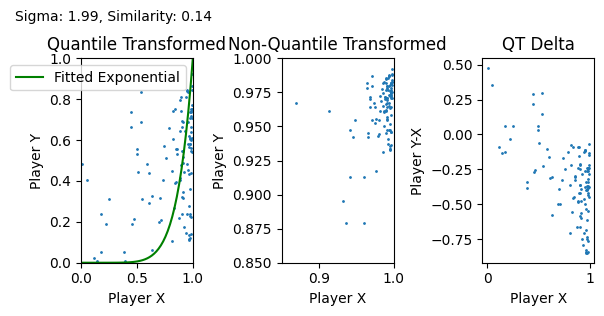

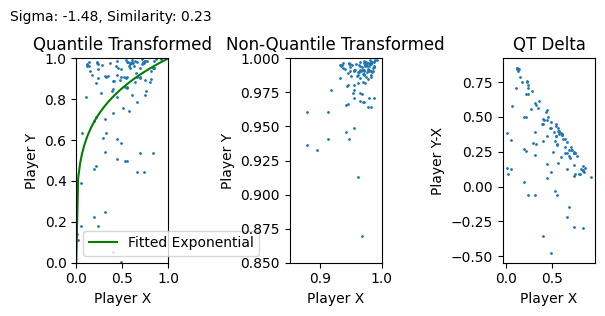

In [170]:
analyze_pair(5, 10)
analyze_pair(10, 5)